In [6]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/aleix11alcacer/Projects/archetypes')

import numpy as np
import torch
from archetypes.datasets import sort_by_archetype_similarity, make_archetypal_dataset, shuffle_dataset
from archetypes.visualization import heatmap
from itertools import product
from sklearn.metrics import normalized_mutual_info_score
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.auto import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
n_archetypes = (3, 3)

# define a numpy generator
generator = np.random.default_rng(7)

archetypes = generator.uniform(0, 1, n_archetypes)
uniform_low = generator.uniform(0, 0.2, n_archetypes)
uniform_high = generator.uniform(0.75, 1, n_archetypes)

archetypes = np.where(archetypes < 0.8, uniform_low, uniform_high)

shape = (100, 100)

alpha = 1

data, labels = make_archetypal_dataset(
    archetypes,
    shape,
    alpha=alpha,
    generator=generator,
    noise=0.1
)

data = np.clip(data, 0, 1)

data = generator.binomial(1, data)  # binarize the data

data_tensor = torch.tensor(data).float().reshape(data.shape)

In [8]:
from models import BiAA, SBM, DBiAA, DSBM
torch.autograd.detect_anomaly(True)
model_i = BiAA(n_archetypes, data_tensor, likelihood="bernoulli", assignment="soft", device="cpu")

model_i.fit(6_000, learning_rate=0.01, threshold=0)

/var/folders/tj/q2qz82qj46qf7mwzd_jqkxnc0000gn/T/ipykernel_23893/1941347208.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  torch.autograd.detect_anomaly(True)


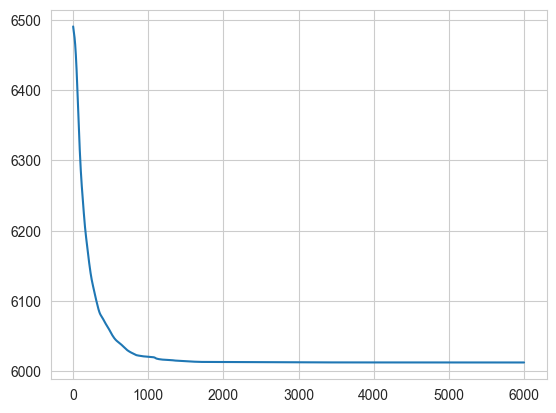

In [9]:
plt.plot(model_i.losses)

In [10]:
print(model_i.losses)

[6490.3505859375, 6489.33251953125, 6488.361328125, 6487.4345703125, 6486.55029296875, 6485.705078125, 6484.892578125, 6484.10791015625, 6483.34326171875, 6482.59375, 6481.85009765625, 6481.10498046875, 6480.3515625, 6479.5810546875, 6478.78857421875, 6477.96826171875, 6477.1142578125, 6476.22412109375, 6475.291015625, 6474.31640625, 6473.294921875, 6472.2255859375, 6471.10791015625, 6469.939453125, 6468.72021484375, 6467.44873046875, 6466.1240234375, 6464.74560546875, 6463.3134765625, 6461.82568359375, 6460.28271484375, 6458.68603515625, 6457.033203125, 6455.32373046875, 6453.55908203125, 6451.7392578125, 6449.8642578125, 6447.93408203125, 6445.94873046875, 6443.91015625, 6441.81884765625, 6439.67431640625, 6437.478515625, 6435.232421875, 6432.9365234375, 6430.59326171875, 6428.20361328125, 6425.76953125, 6423.291015625, 6420.77294921875, 6418.2138671875, 6415.61962890625, 6412.98828125, 6410.32568359375, 6407.630859375, 6404.9091796875, 6402.16162109375, 6399.390625, 6396.599609375, 